### Bag of Words

### helper.py

In [45]:
import cv2
import numpy as np 
from glob import glob
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

class ImageHelpers:
	def __init__(self):
		self.sift_object = cv2.xfeatures2d.SIFT_create()

	def gray(self, image):
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		return gray

	def features(self, image):
		keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
		return [keypoints, descriptors]


class BOVHelpers:
	def __init__(self, n_clusters = 20):
		self.n_clusters = n_clusters
		self.kmeans_obj = KMeans(n_clusters = n_clusters)
		self.kmeans_ret = None
		self.descriptor_vstack = None
		self.mega_histogram = None
		self.clf  = SVC()	
        
	def setClf(self, clf):
		self.clf=clf

	def cluster(self):
		"""	
		cluster using KMeans algorithm, 

		"""
		self.kmeans_ret = self.kmeans_obj.fit_predict(self.descriptor_vstack)

	def developVocabulary(self,n_images, descriptor_list, kmeans_ret = None):
		
		"""
		Each cluster denotes a particular visual word 
		Every image can be represeted as a combination of multiple 
		visual words. The best method is to generate a sparse histogram
		that contains the frequency of occurence of each visual word 

		Thus the vocabulary comprises of a set of histograms of encompassing
		all descriptions for all images

		"""

		self.mega_histogram = np.array([np.zeros(self.n_clusters) for i in range(n_images)])
		old_count = 0
		for i in range(n_images):
			l = len(descriptor_list[i])
			for j in range(l):
				if kmeans_ret is None:
					idx = self.kmeans_ret[old_count+j]
				else:
					idx = kmeans_ret[old_count+j]
				self.mega_histogram[i][idx] += 1
			old_count += l
		#print("Vocabulary Histogram Generated")

	def standardize(self, std=None):
		"""
		
		standardize is required to normalize the distribution
		wrt sample size and features. If not normalized, the classifier may become
		biased due to steep variances.

		"""
		if std is None:
			self.scale = StandardScaler().fit(self.mega_histogram)
			self.mega_histogram = self.scale.transform(self.mega_histogram)
		else:
			#print("STD not none. External STD supplied")
			self.mega_histogram = std.transform(self.mega_histogram)

	def formatND(self, l):
		"""	
		restructures list into vstack array of shape
		M samples x N features for sklearn

		"""
		#print("l: ")
		#print(l)
        
		vStack = np.array(l[0])
		for remaining in l[1:]:
			vStack = np.vstack((vStack, remaining))
		self.descriptor_vstack = vStack.copy()
		return vStack

	def train(self, train_labels):
		"""
		uses sklearn.svm.SVC classifier (SVM) 


		"""
#		print("Training SVM")
#		print(self.clf)
#		print("Train labels", train_labels)
		self.clf.fit(self.mega_histogram, train_labels)
		names = ["Nearest Centroid", "Linear SVM","Decision Tree", "Naive Bayes"]
		classifiers = [NearestCentroid(metric="euclidean"),LinearSVC(dual=False),DecisionTreeClassifier(),GaussianNB()]
        
		for name, clf in zip(names, classifiers):
			scoring = {'acc': 'accuracy','prec': 'precision_macro','rec': 'recall_macro'}
			scores = cross_validate(clf, self.mega_histogram, train_labels, cv=10, scoring=scoring,return_train_score=True)
			print(name," -- Training Set --", "Mean Accuracy", scores['train_acc'].mean())
			print(name," -- Test Set --", "Mean Accuracy", scores['test_acc'].mean())
			print(name," -- Training Set --", "Mean Precision", scores['train_prec'].mean())
			print(name," -- Test Set --", "Mean Precision", scores['test_prec'].mean())
			print(name," -- Training Set --", "Mean Recall", scores['train_rec'].mean())
			print(name," -- Test Set --", "Mean Recall", scores['test_rec'].mean())
			print("Training completed")

	def predict(self, iplist):
		predictions = self.clf.predict(iplist)
		return predictions

	def plotHist(self, vocabulary = None):
		#print("Plotting histogram")
		if vocabulary is None:
			vocabulary = self.mega_histogram

		x_scalar = np.arange(self.n_clusters)
		y_scalar = np.array([abs(np.sum(vocabulary[:,h], dtype=np.int32)) for h in range(self.n_clusters)])

		#print(y_scalar)

		plt.bar(x_scalar, y_scalar)
		plt.xlabel("Visual Word Index")
		plt.ylabel("Frequency")
		plt.title("Complete Vocabulary Generated")
		plt.xticks(x_scalar + 0.4, x_scalar)
		plt.show()

class FileHelpers:

	def __init__(self):
		pass

	def getFiles(self, path):
		"""
		- returns  a dictionary of all files 
		having key => value as  objectname => image path

		- returns total number of files.

		"""
		imlist = {}
		count = 0
		for each in glob(path + "*"):
			each = each.replace("\\", "/")
			word = each.split("/")[-1]
			#print(" #### Reading image category ", word, " ##### ")   
			imlist[word] = []
			for imagefile in glob(path+word+"/*"):
				#print("Reading file ", imagefile)
				im = cv2.imread(imagefile, 0)
				imlist[word].append(im)
				count +=1 
		return [imlist, count]



### kmeans.py

[1 2 1 0 0 0 1 1 0 0 0 1 2 1 1 2 0 0 2 0 1 2 2 2 1 0 2 2 2 0 1 1 0 2 1 2 1
 0 1 2 1 1 2 2 2 1 2 1 2 2 2 2 2 2 0 1 1 0 2 2 1 1 2 0 0 0 2 2 0 0 1 0 0 1
 0 0 2 2 1 0 0 2 0 2 2 1 1 1 2 2 0 0 2 0 1 0 1 2 1 2 1 1 2 0 2 1 0 1 1 0 2
 0 1 0 1 0 1 2 2 0 0 0 0 0 0 0 2 1 2 0 1 1 0 0 1 1 1 2 2 2 1 1 2 2 1 2 2 1
 1 2 1 2 1 1 1 0 2 1 2 2 1 0 0 2 0 2 0 0 0 1 2 0 1 2 0 0 0 2 1 2 2 2 0 1 0
 1 1 2 0 2 2 1 1 1 0 0 0 1 2 2 2 2 0 1 1 1 2 2 0 2 1 2 1 2 1 2 2 0 0 2 0 2
 1 2 0 0 0 0 2 2 2 2 1 2 0 0 0 2 0 1 2 0 1 0 0 1 2 1 1 2 1 0 2 2 0 2 2 1 0
 1 2 1 2 2 1 1 2 1 1 0 0 1 1 2 2 0 2 2 2 1 2 2 1 2 2 2 1 1 0 2 2 1 1 1 0 0
 0 2 1 1 2 0 0 1 1 0 1 2 0 1 1 1 2 0 2 1 2 2 2 1 1 2 1 0 1 1 0 0 0 0 2 0 1
 0 2 0 0 2 1 2 0 1 1 1 2 0 0 2 1 0 1 2 2 2 0 0 1 0 2 1 1 0 1 2 1 2 2 2 1 1
 2 1 1 2 0 1 2 2 0 2 2 2 2 2 2 0 1 0 0 2 0 0 2 1 2 1 0 0 2 2 0 0 1 2 2 0 0
 0 1 0 1 0 2 1 2 0 2 0 1 1 1 0 0 1 2 1 0 2 0 2 2 0 1 1 1 2 2 0 2 2 0 0 0 2
 2 1 2 2 0 1 1 2 0 2 2 2 0 1 2 1 2 0 2 1 2 0 0 1 1 0 1 0 2 0 0 0 1 0 1 0 0
 1 2 2 1 2 1 0 2 1 2 0 2 

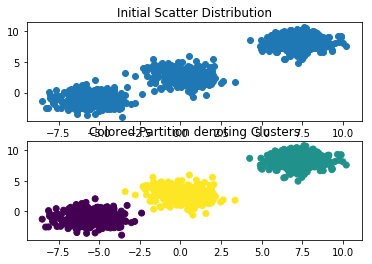

In [37]:
"""
Using SKLearns API for performing Kmeans clustering.
Using sklearn.datasets.make_blobs for generating randomized gaussians
for clustering.

"""

import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs 

# create a dataset sample space that will be used
# to test KMeans. Use function : make_blobs
# 

n_samples = 1000
n_features = 5;
n_clusters = 3;

# aint this sweet 
X, y = make_blobs(n_samples, n_features) 
# X => array of shape [nsamples,nfeatures] ;;; y => array of shape[nsamples]

# X : generated samples, y : integer labels for cluster membership of each sample
# 
# 

# performing KMeans clustering

ret =  KMeans(n_clusters = n_clusters).fit_predict(X)
print(ret)

__, ax = plt.subplots(2)
ax[0].scatter(X[:,0], X[:,1])
ax[0].set_title("Initial Scatter Distribution")
ax[1].scatter(X[:,0], X[:,1], c=ret)
ax[1].set_title("Colored Partition denoting Clusters")
# plt.scatter
plt.show()



### Bag.py

In [49]:
import cv2
import numpy as np 
from glob import glob 
import argparse
#from helpers import *
from matplotlib import pyplot as plt 
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid

class BOV:
    def __init__(self, no_clusters):
        self.no_clusters = no_clusters
        self.train_path = None
        self.test_path = None
        self.im_helper = ImageHelpers()
        self.bov_helper = BOVHelpers(no_clusters)
        self.file_helper = FileHelpers()
        self.images = None
        self.trainImageCount = 0
        self.train_labels = np.array([])
        self.name_dict = {}
        self.name_dict_reverse = {}
        self.descriptor_list = []
        
    def setClf(self, clf):
        self.bov_helper.setClf(clf)
        
    def trainModel(self):
        """
        This method contains the entire module 
        required for training the bag of visual words model

        Use of helper functions will be extensive.

        """
        
        # read file. prepare file lists.
        self.images, self.trainImageCount  = self.file_helper.getFiles(self.train_path)
        
        # extract SIFT Features from each image
        #print("images: ", self.images)
        #print("train image count: ", self.trainImageCount)
        label_count = 0 
        for word, imlist in self.images.items():
            self.name_dict[str(label_count)] = word
            self.name_dict_reverse[word] = label_count
            #print("Computing Features for ", word)
            #print("List: ", imlist)
            for im in imlist:
                # cv2.imshow("im", im)
                # cv2.waitKey()
                self.train_labels = np.append(self.train_labels, label_count)
                kp, des = self.im_helper.features(im)
                self.descriptor_list.append(des)

            label_count += 1
            
        


        # perform clustering
        
        #print(self.descriptor_list)
        bov_descriptor_stack = self.bov_helper.formatND(self.descriptor_list)
        self.bov_helper.cluster()
        self.bov_helper.developVocabulary(n_images = self.trainImageCount, descriptor_list=self.descriptor_list)

        # show vocabulary trained
        # self.bov_helper.plotHist()
 

        self.bov_helper.standardize()
        self.bov_helper.train(self.train_labels)
        
        print("trainModel DONE.")


    def recognize(self,test_img, test_image_path=None):

        """ 
        This method recognizes a single image 
        It can be utilized individually as well.


        """

        kp, des = self.im_helper.features(test_img)
        # print kp
        #print(des.shape)

        # generate vocab for test image
        vocab = np.array( [[ 0 for i in range(self.no_clusters)]])
        # locate nearest clusters for each of 
        # the visual word (feature) present in the image
        
        # test_ret =<> return of kmeans nearest clusters for N features
        test_ret = self.bov_helper.kmeans_obj.predict(des)
        # print test_ret

        # print vocab
        for each in test_ret:
            vocab[0][each] += 1

        #print(vocab)
        # Scale the features
        vocab = self.bov_helper.scale.transform(vocab)

        # predict the class of the image
        lb = self.bov_helper.clf.predict(vocab)
        # print "Image belongs to class : ", self.name_dict[str(int(lb[0]))]
        return lb



    def testModel(self):
        """ 
        This method is to test the trained classifier

        read all images from testing path 
        use BOVHelpers.predict() function to obtain classes of each image

        """
        wordlist=[]
        self.testImages, self.testImageCount = self.file_helper.getFiles(self.test_path)
        
        predictions = []
        correct_labels = []
        for word, imlist in self.testImages.items():
            #print("processing " ,word)
            for im in imlist:
                # print imlist[0].shape, imlist[1].shape
                correct_labels.append(self.name_dict_reverse[word])
                #print(im.shape)
                cl = self.recognize(im)
                #print(cl)
                predictions.append({
                    'image':im,
                    'class':cl,
                    'object_name':self.name_dict[str(int(cl[0]))]
                    })

        #print(predictions)
        #print("CORRECT LABELS:",correct_labels)
        predicted_labels=[]
        for cl in predictions:
            predicted_labels.append(cl['class'])
            
        prec=precision_score(correct_labels, predicted_labels,average='weighted')
        acc=accuracy_score(correct_labels, predicted_labels)
        f1=f1_score(correct_labels, predicted_labels,average='weighted')
        for each in predictions:
            # cv2.imshow(each['object_name'], each['image'])
            # cv2.waitKey()
            # cv2.destroyWindow(each['object_name'])
            # 
            plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
            plt.title(each['object_name'])
            plt.show()
        return [prec,acc,f1]

    def print_vars(self):
        pass
    
    def start(self, train_path, test_path):
        # set training paths
        self.train_path = train_path
        # set testing paths
        self.test_path = test_path
        # train the model
        self.trainModel()
        # test model
        ret=self.testModel()
        return ret

# if __name__ == '__main__':

#     # parse cmd args
#     parser = argparse.ArgumentParser(
#             description=" Bag of visual words example"
#         )
#     parser.add_argument('--train_path', action="store", dest="train_path", required=True)
#     parser.add_argument('--test_path', action="store", dest="test_path", required=True)

#     args =  vars(parser.parse_args())
#     print(args)

    
#     bov = BOV(no_clusters=100)

#     # set training paths
#     bov.train_path = args['train_path'] 
#     # set testing paths
#     bov.test_path = args['test_path'] 
#     # train the model
#     bov.trainModel()
#     # test model
#     bov.testModel()


D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\cla

Nearest Centroid  -- Training Set -- Mean Accuracy 0.8788461538461538
Nearest Centroid  -- Test Set -- Mean Accuracy 0.8375
Nearest Centroid  -- Training Set -- Mean Precision 0.8803706648743412
Nearest Centroid  -- Test Set -- Mean Precision 0.8058333333333334
Nearest Centroid  -- Training Set -- Mean Recall 0.8788461538461538
Nearest Centroid  -- Test Set -- Mean Recall 0.8375
Training completed
Linear SVM  -- Training Set -- Mean Accuracy 1.0
Linear SVM  -- Test Set -- Mean Accuracy 0.9
Linear SVM  -- Training Set -- Mean Precision 1.0
Linear SVM  -- Test Set -- Mean Precision 0.9083333333333332
Linear SVM  -- Training Set -- Mean Recall 1.0
Linear SVM  -- Test Set -- Mean Recall 0.9
Training completed
Decision Tree  -- Training Set -- Mean Accuracy 1.0
Decision Tree  -- Test Set -- Mean Accuracy 0.775
Decision Tree  -- Training Set -- Mean Precision 1.0
Decision Tree  -- Test Set -- Mean Precision 0.7291666666666666
Decision Tree  -- Training Set -- Mean Recall 1.0
Decision Tree  -

D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\cla

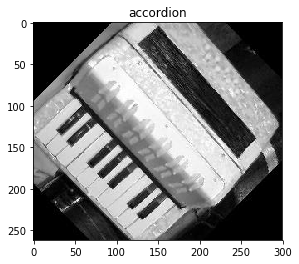

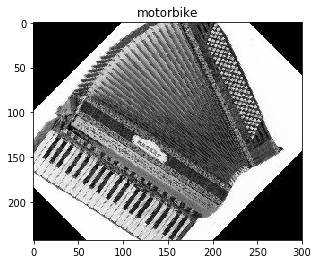

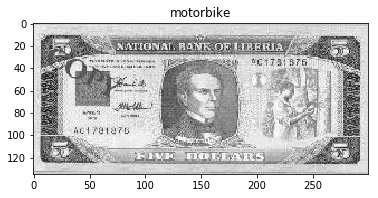

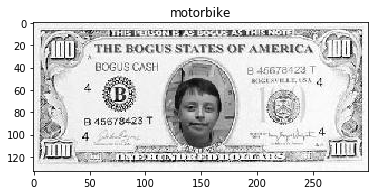

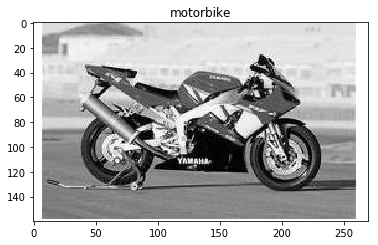

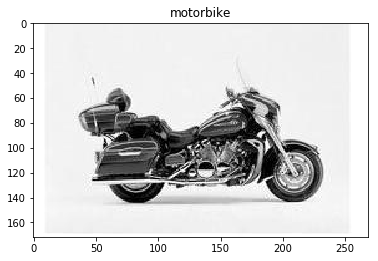

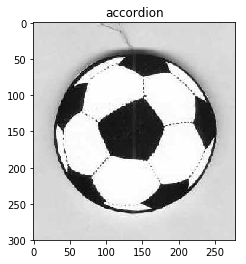

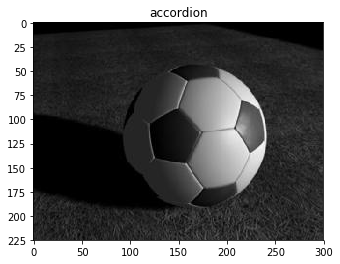

[0.18333333333333335, 0.375, 0.24285714285714288]


In [50]:
bov = BOV(no_clusters=100)
clf=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
bov.setClf(clf)
res=bov.start("images/train/", "images/test/")
print(res)